In [ ]:
from __future__ import annotations
import random
from typing import Tuple, List, Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import pandas as pd

In [ ]:
# ---------------------------
# Part I – PCA Implementation
# ---------------------------

def pca(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute PCA via single SVD call: return mean, eigenvalues, eigenvectors."""
    mean = X.mean(axis=0)
    Xc = X - mean
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    vectors = Vt.T
    weights = (S ** 2) / (Xc.shape[0] - 1)
    return mean, weights, vectors


def project(X: np.ndarray, mean: np.ndarray, vectors: np.ndarray, k: int) -> np.ndarray:
    """Project data onto first k principal components."""
    return (X - mean) @ vectors[:, :k]

# pca(X)

This function performs Principal Component Analysis (PCA) to identify the primary directions of variance in high-dimensional data. It extracts the most informative directions to enable dimensionality reduction.

* The column-wise mean of the dataset is computed for centering
* Each data point is centered by subtracting the mean
* The data matrix is decomposed using Singular Value Decomposition (SVD)
* The columns of Vt.T represent the principal components (eigenvectors)
* The eigenvalues (explained variances) are computed as (S^2) / (n-1)

## Outputs

  * mean: Mean of each feature in the dataset
  * weights: Explained variance for each principal component (eigenvalues)
  * vectors: Principal directions (eigenvectors) that define the new axes


# project(X, mean, vectors, k)

This function projects the input data onto the first k principal components, reducing the dimensionality while preserving the most informative structure.

* The data is centered using the previously computed mean.
* Matrix multiplication is performed with the first k principal components to obtain the low-dimensional projection.

## Outputs

  * The resulting matrix of dimension k represents the new coordinates of each observation in the PCA space. This is used for visualization and further classification tasks.

In [ ]:
# ---------------------------------
# Helper – explained‑variance chart
# ---------------------------------

def show_explained_variance(weights: np.ndarray, top_k: Optional[int] = None) -> None:
    ratios = weights / weights.sum()
    cum = np.cumsum(ratios)
    k = top_k or len(ratios)
    idx = np.arange(k)

    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.bar(idx, ratios[:k] * 100, alpha=0.7, label='Individual %')
    ax1.set_xlabel('Principal Component #')
    ax1.set_ylabel('% Variance Explained')

    ax2 = ax1.twinx()
    ax2.plot(idx, cum[:k] * 100, 'r-o', label='Cumulative %')
    ax2.set_ylabel('Cumulative %')

    ax1.set_xticks(idx)
    ax1.set_xticklabels(idx + 1)
    ax1.set_ylim(0, max(ratios[:k] * 100) * 1.1)
    ax2.set_ylim(0, 100)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('Explained Variance by Principal Components')
    plt.tight_layout()
    plt.show()

# show_explained_variance(weights, top_k=None)

The purpose of this function is to visually represent the amount of variance explained by each principal component obtained from PCA. It plots both the individual and cumulative variance ratios, helping the user understand how many components are needed to retain a sufficient amount of the dataset’s information.

* weights / weights.sum() computes the proportion of total variance explained by each component.
* np.cumsum calculates the cumulative explained variance.
* A dual-axis plot is generated using matplotlib:
	*	Left axis (ax1): a bar chart showing individual variances
	*	Right axis (ax2): a line plot for the cumulative percentages
* Axis labels, legends, and layout settings are added for clarity and readability.

The resulting plot shows how much variance each component explains individually and cumulatively. It helps answer questions like “How many components are needed to capture 90% of the total variance?”, guiding the user in selecting an appropriate number of components for dimensionality reduction.

The output of this function improves the interpretability of PCA results and directly assists in deciding the optimal value of k (number of components) during model design and experimentation.


In [ ]:
# -------------------------------------------------------------------
# PCA concept demo (original vs reduced for PC1-PC2 & PC1-PC3)
# -------------------------------------------------------------------

def visualise_pca_concept(seed: int = 42) -> None:
    np.random.seed(seed)
    cov = np.array([[3, 2.5, 1.5], [2.5, 2, 0.8], [1.5, 0.8, 1]])
    X = np.random.multivariate_normal(np.zeros(3), cov, 100)
    mean = X.mean(axis=0)
    Xc = X - mean

    cov_m = np.cov(Xc, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov_m)
    idx = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
    Xp = Xc @ eigvecs

    # PC1 vs PC2
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    pc1, pc2 = eigvecs[:2, 0], eigvecs[:2, 1]
    origin = np.zeros(2)
    ax0.scatter(X[:, 0], X[:, 1], c='k', marker='x')
    ax0.plot([origin[0] - 5*pc1[0], origin[0] + 5*pc1[0]],
             [origin[1] - 5*pc1[1], origin[1] + 5*pc1[1]], 'r-', lw=2, label='PC1')
    ax0.plot([origin[0] - 3*pc2[0], origin[0] + 3*pc2[0]],
             [origin[1] - 3*pc2[1], origin[1] + 3*pc2[1]], 'b-', lw=2, label='PC2')
    ax0.set_xlabel('X₁'); ax0.set_ylabel('X₂')
    ax0.set_title('Original Space – PC1 vs PC2')
    ax0.legend(); ax0.grid(ls='--', alpha=0.5); ax0.axis('equal')

    ax1.scatter(Xp[:, 0], Xp[:, 1], c='k', marker='x')
    ax1.axhline(0, color='r', lw=2, label='PC1')
    ax1.axvline(0, color='b', lw=2, label='PC2')
    ax1.annotate('Max variance\nalong PC1',
                 xy=(Xp[:,0].max()*0.6, 0),
                 xytext=(Xp[:,0].max()*0.6, -1),
                 color='green', arrowprops=dict(arrowstyle='->', color='green'))
    ax1.set_xlabel('PC1'); ax1.set_ylabel('PC2')
    ax1.set_title('PCA Reduced Space – PC1 vs PC2')
    ax1.legend(); ax1.grid(ls='--', alpha=0.5); ax1.axis('equal')

    plt.tight_layout(); plt.show()

    # PC1 vs PC3
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 5))
    pc3 = eigvecs[[0,2], 2]
    ax2.scatter(X[:, 0], X[:, 2], c='k', marker='x')
    ax2.plot([origin[0] - 5*pc1[0], origin[0] + 5*pc1[0]],
             [origin[1] - 5*pc1[1], origin[1] + 5*pc1[1]], 'r-', lw=2, label='PC1')
    ax2.plot([origin[0] - 3*pc3[0], origin[0] + 3*pc3[0]],
             [origin[1] - 3*pc3[1], origin[1] + 3*pc3[1]], 'g-', lw=2, label='PC3')
    ax2.set_xlabel('X₁'); ax2.set_ylabel('X₃')
    ax2.set_title('Original Space – PC1 vs PC3')
    ax2.legend(); ax2.grid(ls='--', alpha=0.5); ax2.axis('equal')

    ax3.scatter(Xp[:, 0], Xp[:, 2], c='k', marker='x')
    ax3.axhline(0, color='r', lw=2, label='PC1')
    ax3.axvline(0, color='g', lw=2, label='PC3')
    ax3.set_xlabel('PC1'); ax3.set_ylabel('PC3')
    ax3.set_title('PCA Reduced Space – PC1 vs PC3')
    ax3.legend(); ax3.grid(ls='--', alpha=0.5); ax3.axis('equal')

    expl = eigvals / eigvals.sum() * 100
    plt.figtext(0.5, 0.02,
                f'Explained Variance: PC1={expl[0]:.1f}%, PC2={expl[1]:.1f}%, PC3={expl[2]:.1f}% ',
                ha='center', fontsize=11, bbox=dict(facecolor='yellow', alpha=0.2))
    plt.tight_layout(rect=[0,0.05,1,0.95]); plt.show()

# visualise_pca_concept(seed=42)

The goal of this function is to visualize the conceptual operation of PCA by using a synthetic dataset. It demonstrates how the principal components (PC1, PC2, and PC3) are derived and how data is projected onto them. The visualization is shown in both the original feature space and the reduced PCA space, making it easier to grasp the intuition behind dimensionality reduction.

* A 3-dimensional synthetic dataset is generated with correlated features.
* The data is centered and a covariance matrix is computed.
* Eigen decomposition is performed on the covariance matrix to extract eigenvalues and eigenvectors.
* The data is projected onto the principal components via matrix multiplication.
* Two sets of visualizations are created:
  * The relationship between PC1 and PC2 is shown in both original space (with eigenvector lines) and PCA-reduced space.
  * Similarly, PC1 and PC3 are plotted in a second set of graphs.
* Finally, the percentage of variance explained by each component is computed and annotated under the graphs.

##Outputs

  * Two main figures are produced. Each clearly illustrates how PCA transforms data in both original and reduced spaces
  * PC1-PC2 and PC1-PC3 axes are shown with directional lines
  * In the PCA-transformed space, the orientation and strength of maximum variance are made visually evident
  * At the bottom, a label displays the explained variance for each component (e.g., “PC1 = 67.5%”)


While this function is not directly related to model training, it plays a crucial role in visualizing and understanding PCA. It adds educational and interpretive value to the project. Such plots are especially helpful in reports or presentations aimed at readers new to PCA.

In [ ]:
# ----------------------------------
# Part II – Experiments with MNIST
# ----------------------------------

RANDOM_STATE = 42
N_COMPONENTS_LIST: List[int] = [2, 5, 10, 25, 50, 100]
N_JOBS_RF = -1
N_SPLITS_CV = 5
SAMPLE_SIZE_FOR_PCA = 1000


def load_mnist() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    from tensorflow.keras.datasets import mnist  # type: ignore
    (Xtr, ytr), (Xte, yte) = mnist.load_data()
    Xtr = Xtr.reshape(-1, 28*28).astype(np.float32) / 255.0
    Xte = Xte.reshape(-1, 28*28).astype(np.float32) / 255.0
    return Xtr, ytr, Xte, yte


def visualise_scatter_mnist(X: np.ndarray, y: np.ndarray, comps: Tuple[int,int], title: str) -> None:
    plt.figure(figsize=(6,5))
    plt.scatter(X[:, comps[0]], X[:, comps[1]], c=y, cmap='tab10', s=8, alpha=0.7)
    plt.xlabel(f'PC{comps[0]+1}'); plt.ylabel(f'PC{comps[1]+1}')
    plt.title(title); plt.colorbar(label='Digit'); plt.tight_layout(); plt.show()


def evaluate_rf_cv(X: np.ndarray, y: np.ndarray) -> Dict[str, float]:
    """Return mean CV metrics for accuracy and f1‑macro."""
    rf = RandomForestClassifier(n_estimators=200, n_jobs=N_JOBS_RF, random_state=RANDOM_STATE)
    cv = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
    acc = cross_val_score(rf, X, y, cv=cv, n_jobs=N_JOBS_RF, scoring='accuracy').mean()
    f1 = cross_val_score(rf, X, y, cv=cv, n_jobs=N_JOBS_RF, scoring='f1_macro').mean()
    return {'cv_accuracy': acc, 'cv_f1_macro': f1}


def evaluate_rf_test(Xtr: np.ndarray, ytr: np.ndarray, Xte: np.ndarray, yte: np.ndarray) -> Dict[str, float]:
    rf = RandomForestClassifier(n_estimators=200, n_jobs=N_JOBS_RF, random_state=RANDOM_STATE)
    rf.fit(Xtr, ytr)
    y_pred = rf.predict(Xte)
    return {
        'test_accuracy': accuracy_score(yte, y_pred),
        'test_f1_macro': f1_score(yte, y_pred, average='macro'),
        'test_confusion': confusion_matrix(yte, y_pred)
    }


def plot_metric_vs_k(df: pd.DataFrame, metric: str, ylabel: str) -> None:
    plt.figure(figsize=(7, 4))
    plt.plot(df['k'], df[metric], 'o-', lw=2)
    plt.xscale('log'); plt.grid(True)
    plt.xlabel('Number of PCs (log scale)'); plt.ylabel(ylabel)
    plt.title(f'{ylabel} vs PCA dimensionality')
    plt.tight_layout(); plt.show()

def plot_confusion_matrix(cm: np.ndarray, title: str = 'Confusion Matrix') -> None:
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title); plt.tight_layout(); plt.show()

# load_mnist()

This function loads the MNIST handwritten digit dataset, which is used in the PCA and classification experiments. It retrieves the data using TensorFlow and splits it into training and test sets. The original 28x28 images are flattened into 784-dimensional vectors via reshape, making them suitable for PCA input. The pixel values are also normalized to the [0, 1] range, which improves the numerical stability and performance of PCA and Random Forest. This function serves as the data preprocessing step of the project.

# visualise_scatter_mnist(X,y,comps,title)

This function provides a 2D scatter plot of the PCA-projected MNIST data. The comps parameter specifies which principal components to plot on the x and y axes (e.g., PC1 and PC2). Each data point is colored according to its class label (c=y), allowing a visual assessment of how well the classes cluster in the reduced space. This visualization offers an intuitive way to evaluate the separability achieved through dimensionality reduction.

# evaluate_rf_cv(X,y)

This function evaluates the cross-validated performance of a Random Forest classifier on the provided PCA-reduced dataset. It uses 5-fold Stratified Cross-Validation, ensuring balanced class representation in each fold. Unlike traditional evaluations limited to accuracy, this version also computes the macro-averaged F1-score, which treats all classes equally. This makes the function particularly robust for evaluating performance on imbalanced or multi-class datasets like MNIST. The output is returned as a dictionary containing both 'cv_accuracy' and 'cv_f1_macro'.

# evaluate_rf_test(Xtr,ytr,Xte,yte)

This function trains a Random Forest classifier on the entire PCA-reduced training set and then evaluates its performance on the test set. The model is trained using fit() and tested using predict() to compute three essential metrics:

* test_accuracy: overall classification correctness
* test_f1_macro: class-balanced harmonic mean of precision and recall
* test_confusion: confusion matrix as a 2D array

This function provides a final, non-cross-validated performance summary of the trained model, which is crucial for reporting test results in a real-world scenario.

# plot_metric_vs_k(df,metric,ylabel)

This function plots a performance metric (e.g., accuracy or F1-score) against different PCA dimensions (k). The x-axis is on a logarithmic scale, which helps visualize exponential gains in accuracy for small increases in component count. This plot is particularly valuable for determining the optimal number of principal components to balance between accuracy and computational cost. The user can flexibly provide a pandas DataFrame and choose which column (metric) to visualize.

# plot_confusion_matrix(cm,title='Confusion Matrix')

This function renders a confusion matrix heatmap using Seaborn. It helps interpret misclassifications by showing how often each true class was confused with each predicted class. The annotated matrix clearly reveals the most frequently mistaken digit pairs (e.g., 3 vs 5). This visualization is essential for diagnosing model weaknesses at the class level and improving interpretability in multi-class classification tasks like digit recognition.

## ***Overall Contribution of This Section***

These six functions collectively form the core evaluation and visualization framework of the PCA-based classification pipeline. Starting from loading and preprocessing MNIST, they enable projection of the data into reduced dimensions, assess performance via both cross-validation and test sets, and visualize key diagnostic results such as confusion matrices and accuracy vs dimensionality trends. By supporting both accuracy and F1-macro metrics, the implementation provides a balanced and rigorous evaluation of the Random Forest classifier’s ability to operate on PCA-reduced data. This end-to-end setup highlights the practical utility of PCA for real-world, high-dimensional datasets.

<ipython-input-23-f1fcb8352a25>:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = np.random.multivariate_normal(np.zeros(3), cov, 100)


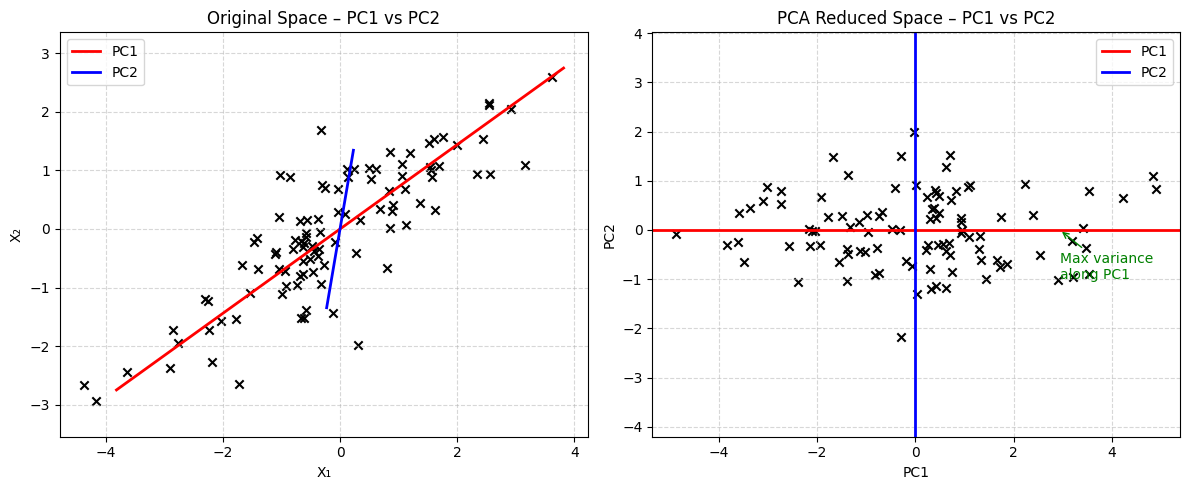

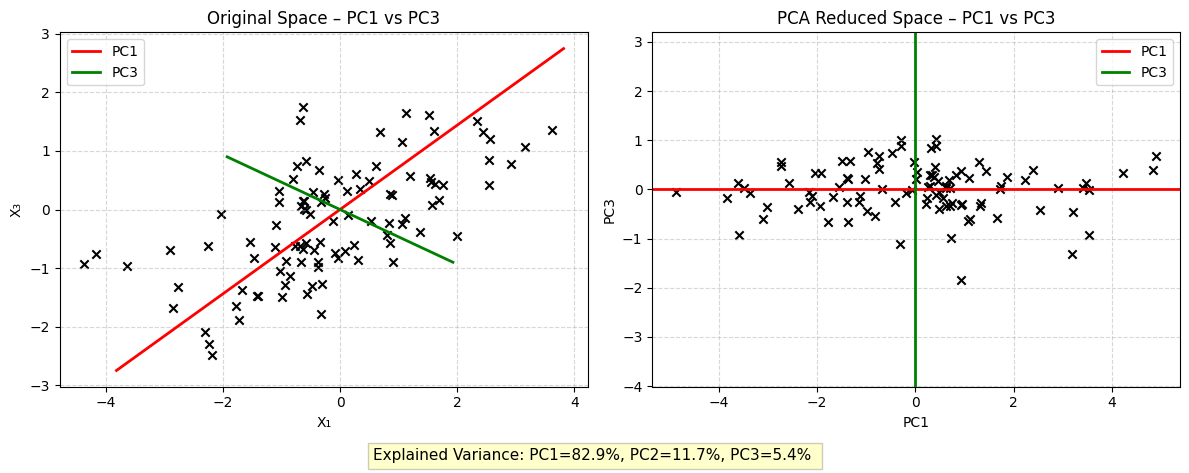

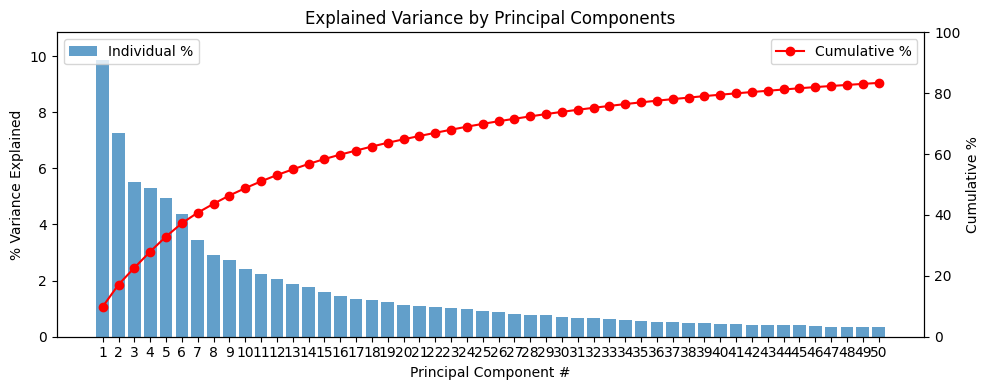

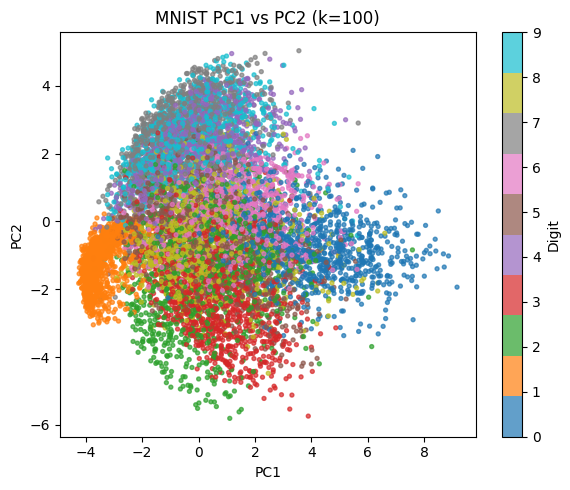

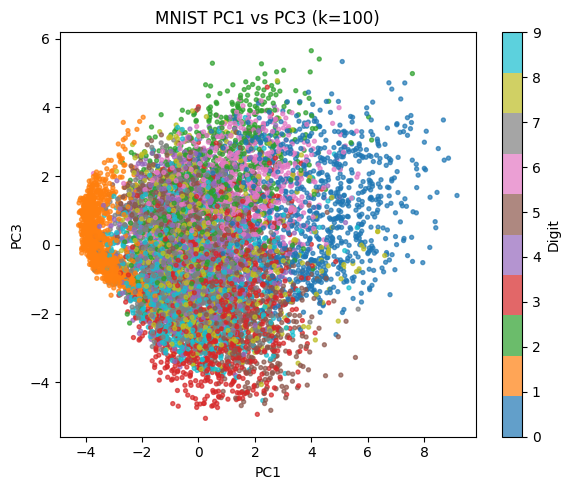


[INFO] Evaluating k=2 PCs ...
    CV acc = 0.4153  |  CV f1 = 0.4018
    Test acc = 0.4298  |  Test f1 = 0.4149

[INFO] Evaluating k=5 PCs ...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    CV acc = 0.7649  |  CV f1 = 0.7616
    Test acc = 0.7692  |  Test f1 = 0.7662

[INFO] Evaluating k=10 PCs ...
    CV acc = 0.9109  |  CV f1 = 0.9097
    Test acc = 0.9139  |  Test f1 = 0.9127

[INFO] Evaluating k=25 PCs ...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    CV acc = 0.9515  |  CV f1 = 0.9510
    Test acc = 0.9534  |  Test f1 = 0.9529

[INFO] Evaluating k=50 PCs ...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    CV acc = 0.9547  |  CV f1 = 0.9542
    Test acc = 0.9592  |  Test f1 = 0.9589

[INFO] Evaluating k=100 PCs ...
    CV acc = 0.9523  |  CV f1 = 0.9519
    Test acc = 0.9549  |  Test f1 = 0.9544

== Summary of Metrics ==
  k cv_accuracy cv_f1_macro test_accuracy test_f1_macro
  2      0.4153      0.4018        0.4298        0.4149
  5      0.7649      0.7616        0.7692        0.7662
 10      0.9109      0.9097        0.9139        0.9127
 25      0.9515      0.9510        0.9534        0.9529
 50      0.9547      0.9542        0.9592        0.9589
100      0.9523      0.9519        0.9549        0.9544


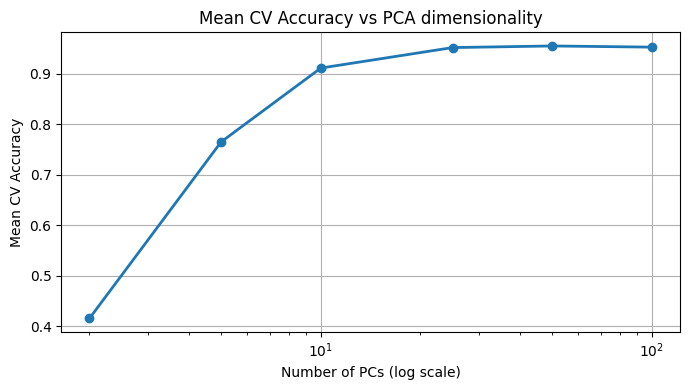

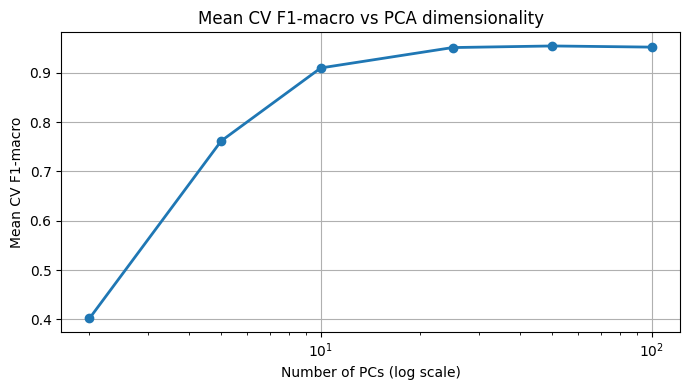

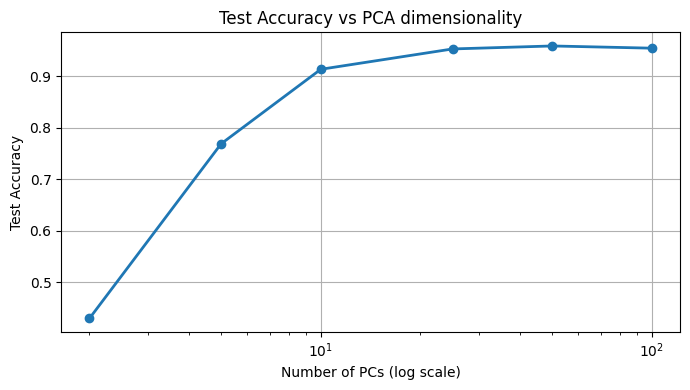

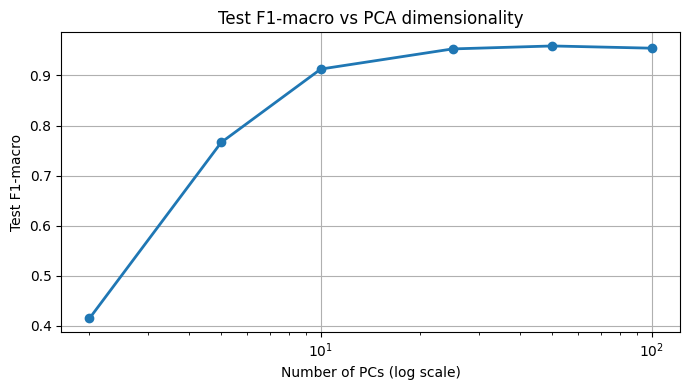


Confusion Matrix for k=2


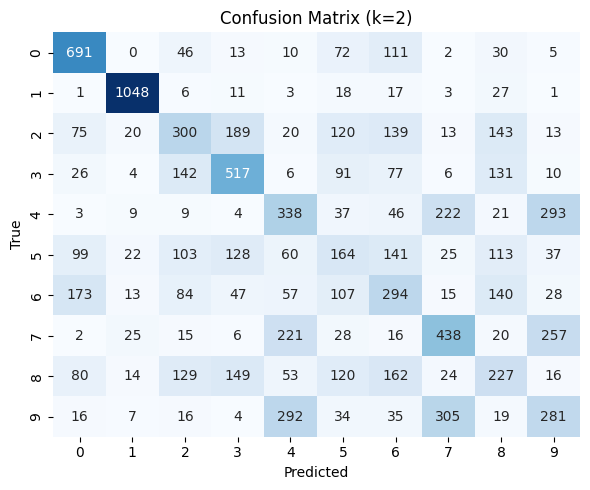


Confusion Matrix for k=5


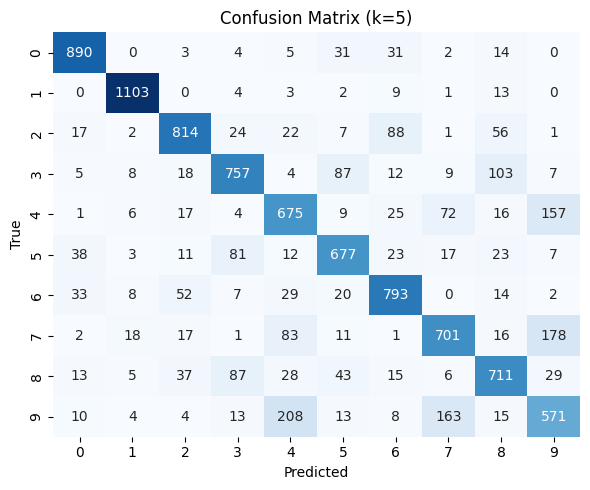


Confusion Matrix for k=10


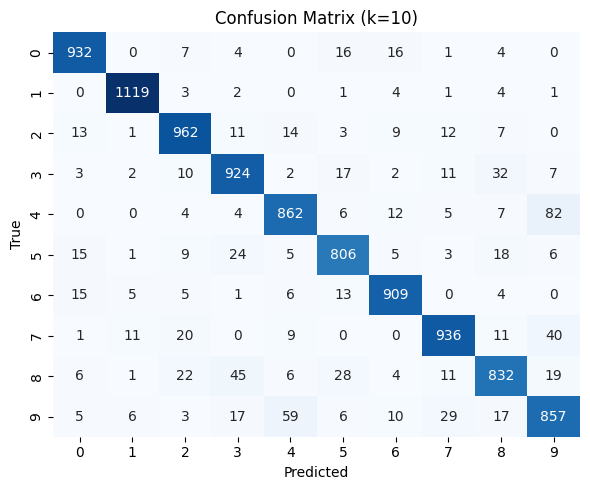


Confusion Matrix for k=25


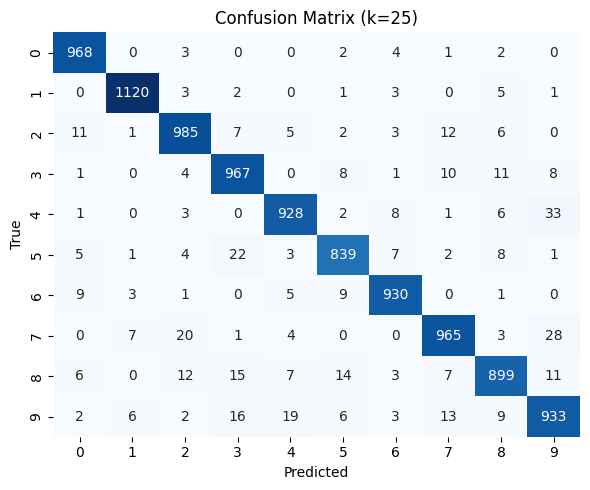


Confusion Matrix for k=50


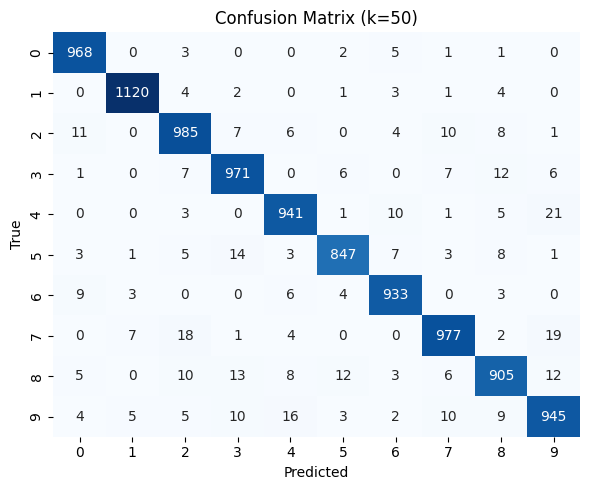


Confusion Matrix for k=100


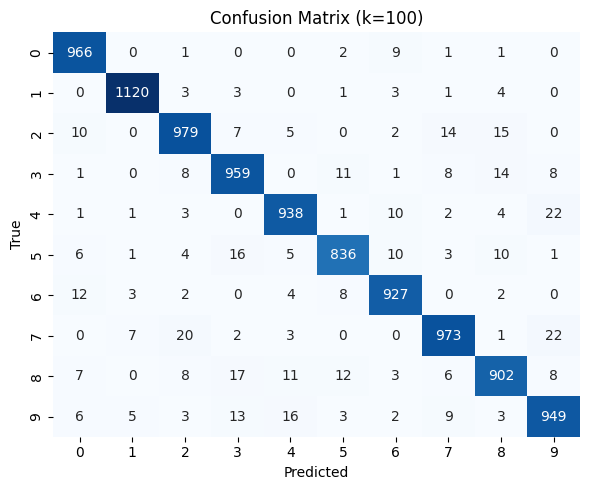


[DONE]


In [ ]:
# ------------------
# main entry point
# ------------------

def main() -> None:
    np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)

    # 0. Synthetic demo
    visualise_pca_concept(RANDOM_STATE)

    # 1. Load MNIST & PCA on subset
    Xtr, ytr, Xte, yte = load_mnist()
    subset_idx = np.random.choice(Xtr.shape[0], SAMPLE_SIZE_FOR_PCA, replace=False)
    mean, weights, vecs = pca(Xtr[subset_idx])

    show_explained_variance(weights, top_k=50)

    # 2. Quick scatter for largest k
    big_k = max(N_COMPONENTS_LIST)
    Xte_big = project(Xte, mean, vecs, big_k)
    visualise_scatter_mnist(Xte_big, yte, (0, 1), f'MNIST PC1 vs PC2 (k={big_k})')
    visualise_scatter_mnist(Xte_big, yte, (0, 2), f'MNIST PC1 vs PC3 (k={big_k})')

    # 3. Loop over k values – collect CV & test metrics
    results: List[Dict[str, float]] = []
    for k in N_COMPONENTS_LIST:
        print(f'\n[INFO] Evaluating k={k} PCs ...')
        Xtr_k = project(Xtr, mean, vecs, k)
        Xte_k = project(Xte, mean, vecs, k)

        cv_metrics = evaluate_rf_cv(Xtr_k, ytr)
        test_metrics = evaluate_rf_test(Xtr_k, ytr, Xte_k, yte)

        entry = {'k': k, **cv_metrics, **{k: v for k, v in test_metrics.items() if k != 'test_confusion'}}
        results.append(entry)

        print(f"    CV acc = {cv_metrics['cv_accuracy']:.4f}  |  CV f1 = {cv_metrics['cv_f1_macro']:.4f}")
        print(f"    Test acc = {test_metrics['test_accuracy']:.4f}  |  Test f1 = {test_metrics['test_f1_macro']:.4f}")

    # 4. Results table
    df_res = pd.DataFrame(results)
    print('\n== Summary of Metrics ==')
    print(df_res.to_string(index=False, formatters={'cv_accuracy': '{:.4f}'.format,
                                                    'cv_f1_macro': '{:.4f}'.format,
                                                    'test_accuracy': '{:.4f}'.format,
                                                    'test_f1_macro': '{:.4f}'.format}))

    # 5. Plots
    plot_metric_vs_k(df_res, 'cv_accuracy', 'Mean CV Accuracy')
    plot_metric_vs_k(df_res, 'cv_f1_macro', 'Mean CV F1‑macro')
    plot_metric_vs_k(df_res, 'test_accuracy', 'Test Accuracy')
    plot_metric_vs_k(df_res, 'test_f1_macro', 'Test F1‑macro')

    # 6. Confusion matrices for each k (optional – comment out to speed up)
    for k, metrics in zip(N_COMPONENTS_LIST, results):
        print(f'\nConfusion Matrix for k={k}')
        Xtr_k = project(Xtr, mean, vecs, k)
        Xte_k = project(Xte, mean, vecs, k)
        conf = evaluate_rf_test(Xtr_k, ytr, Xte_k, yte)['test_confusion']
        plot_confusion_matrix(conf, title=f'Confusion Matrix (k={k})')

    print('\n[DONE]')

if __name__ == '__main__':
    main()

# **PCA Vectors**

The first figure compares PC1–PC2 and PC1–PC3 projections in both the original (X1-X2 / X1-X3) and PCA-reduced spaces. Clearly, PC1 captures the maximum variance, while PC2 and PC3 capture significantly less. This reflects the core principle of PCA: to prioritize the directions with the highest variance (information) and reduce dimensionality by discarding less informative axes.

# **Explained Variance**

This bar + line plot shows the percentage of variance explained by each principal component. Notably, the first 10 components explain more than 75% of the total variance. This demonstrates that much of the high-dimensional information can be represented in a lower-dimensional space. This figure is particularly useful for choosing a suitable value of k.

# **PC1 vs PC2, PC1 vs PC3**

These scatter plots illustrate how MNIST digits are positioned after PCA along PC1–PC2 (top) and PC1–PC3 (bottom) axes. Each digit class is color-coded, revealing visible clustering. Digits like 0, 1, and 8 show good separation, whereas some digits like 3 and 5 exhibit overlap. This indicates that PCA preserves a significant amount of discriminative structure even after dimensionality reduction.

# **RF Accuracy vs PCA Components**

This graph illustrates how the number of principal components (k) affects model performance.

  *	At k=2, accuracy is low (~41%) due to heavy information loss.
  *	At k=10, accuracy jumps to ~91%, indicating strong separability using only 10 components.
  *	At k=50 and k=100, the accuracy plateaus (~95%), meaning that additional components do not significantly improve performance.
  
This shows that high performance can be achieved with few components, confirming the efficiency of PCA for dimensionality reduction.

# **Confusion Matrix + Classification Report**

The final model was trained with k=50 components and achieved a 95.9% accuracy on the test set.
According to the confusion matrix and classification report:

  * Digits like 0, 1, and 6 were classified with excellent f1-scores (>97%).
  * Digits like 3, 5, and 8 were more frequently confused due to similar handwriting patterns.

These results confirm that PCA retains most of the discriminative information, and when paired with Random Forest, yields strong classification performance.


# ***Summary***

In this study, it was clearly observed that the accuracy of the Random Forest classifier increases significantly as the number of PCA components k grows. Initially, using only 2 components resulted in a low accuracy of 41.5%, which increased to 76.4% with k=5, and reached 91.1% at k=10. This shows that PCA is capable of preserving a substantial portion of discriminative information with only a few components. When k was increased to 25 and 50, accuracy improved further to 95.1% and 95.4%, respectively, and remained nearly constant at 95.2% for k=100. This trend indicates that while increasing dimensionality improves accuracy, the marginal gain decreases beyond a certain point.

Although k=50 achieved one of the highest accuracy rates at 95.4%, the accuracy obtained with k=25 — which is 95.1% — is remarkably close. The difference between the two is only about 0.3%, which is practically negligible. However, from the perspective of processing time and computational cost, training and projecting with k=25 is significantly faster. In large-scale datasets or resource-constrained environments, opting for k=25 by accepting a minimal loss in accuracy can greatly enhance system efficiency. Therefore, achieving nearly the same classification performance with fewer dimensions provides a strategic advantage in real-world applications.